In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
preds = pd.read_pickle('weeds_16_preds.pkl')
truth = pd.read_pickle('weeds_16_truth.pkl')
filenames = pd.read_pickle('weeds_16_filenames.pkl')



Confusion matrix, without normalization
[[ 505    6    0  157]
 [   4  704    1   30]
 [   0    1   45    1]
 [ 113   36    0 1827]]
Normalized confusion matrix
[[0.76 0.01 0.   0.24]
 [0.01 0.95 0.   0.04]
 [0.   0.02 0.96 0.02]
 [0.06 0.02 0.   0.92]]


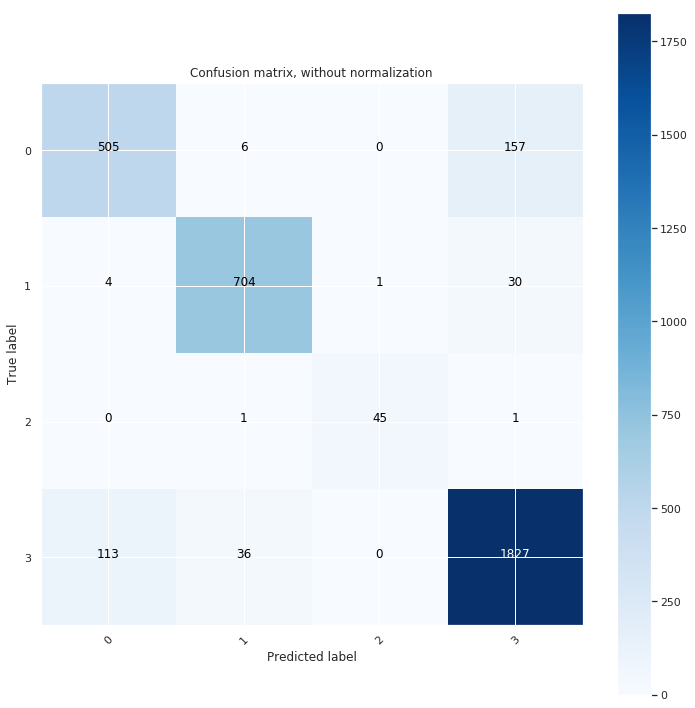

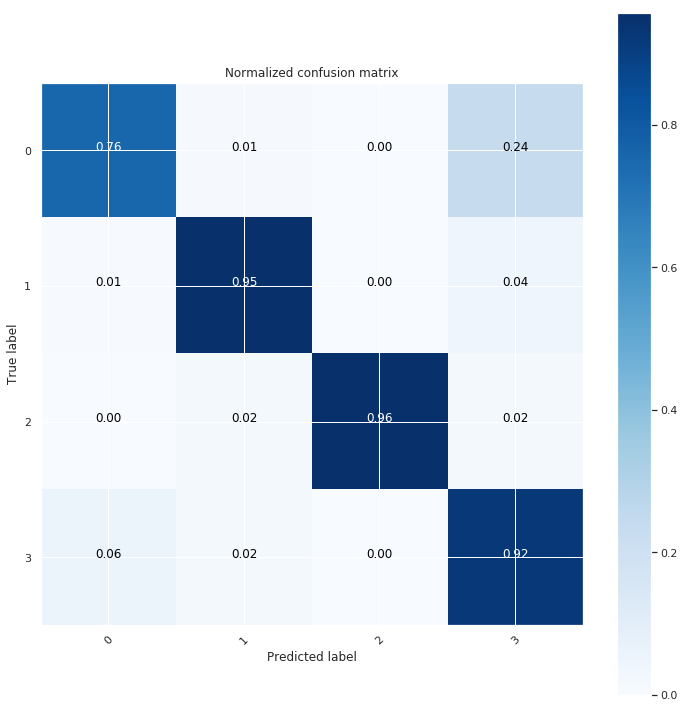

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cnf_matrix = confusion_matrix(truth, preds)
np.set_printoptions(precision=2)

class_names = {0:'forbs', 1:'grass', 2:'ground', 3:'weeds'}
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [11]:
test_dict = dict(sub_images='total', grass='pct_grass', ground='pct_ground', forbs='pct_forbs', weeds='pct_weeds',
               pred_mat='output', prob_mat='output2', all_prob_mat='list_probs')

list(test_dict.values())


['total',
 'pct_grass',
 'pct_ground',
 'pct_forbs',
 'pct_weeds',
 'output',
 'output2',
 'list_probs']

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap != None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, annot_kws={"size": 20}, fmt='', ax=ax, cmap=sns.color_palette("Oranges"))
    #plt.savefig(filename)

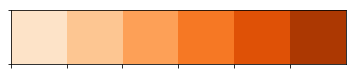

In [25]:
sns.palplot(sns.color_palette("Oranges"))

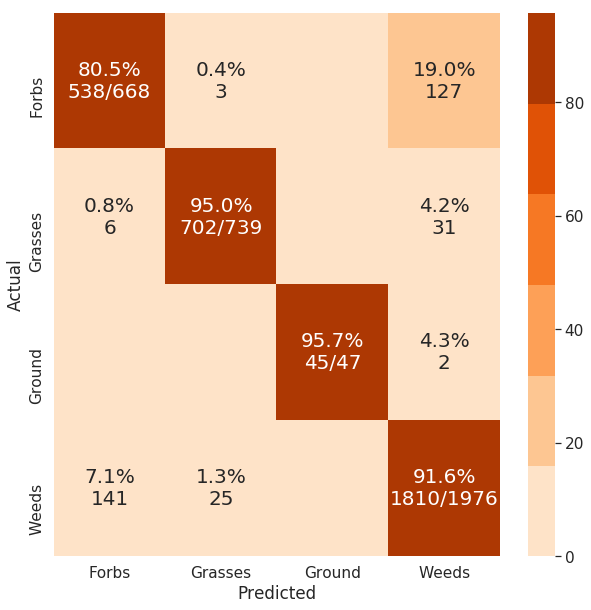

In [29]:
sns.set(font_scale=1.4) 
truth = pd.read_pickle('weeds_16_truth.pkl')
preds = pd.read_pickle('weeds_16_preds.pkl')
cm_analysis(truth, preds, 'heat', [0,1,2,3], ymap={0:'Forbs', 1:'Grasses', 2:'Ground', 3:'Weeds'})

In [4]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
#from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras_applications import vgg19
from keras.applications import Xception
from keras.applications.imagenet_utils import decode_predictions
from keras import models
from keras import layers
from keras import optimizers

from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

import keras_metrics 
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import metrics

import cv2

#variables
SEED = 11
RUN = 6
CROP_LENGTH = 224

#functions
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        value, update = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update]):
            value = tf.identity(value)
        return value
    return wrapper

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    '''
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    '''
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)


#Load vgg16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# # Unfreeze top layer 
# base_model.trainable = True
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False


#Build architecture
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5)) 
model.add(layers.Dense(4, activation='softmax'))
model.summary()

base_dir = '/home/ubuntu/open sprayer/broad_class_weeds/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#callbacks
prec = as_keras_metric(metrics.precision)
auc = as_keras_metric(metrics.auc)

csv_logger = keras.callbacks.CSVLogger('weeds_{}.log'.format(RUN))
save_best = keras.callbacks.ModelCheckpoint('weeds{}.hdf5'.format(RUN), monitor='val_loss', verbose=1, save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)                                             
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,# using a directory with pre-augmented images + originals
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    fill_mode = 'nearest', # fill gaps generated by shears/other augmentatio
                    #validation_split=0.2,
                    )

train_datagen.config['random_crop_size'] = (224,224)
# train_datagen = ImageDataGenerator(
#                     rescale = 1./255,
#                     rotation_range = 60,# using a directory with pre-augmented images + originals
#                     width_shift_range = 0.4,
#                     height_shift_range = 0.4,
#                     shear_range = 0.2,
#                     zoom_range = 0.4,
#                     horizontal_flip = True,
#                     fill_mode = 'nearest', # fill gaps generated by shears/other augmentatio
#                     validation_split=0.2,
#                     )


test_datagen = ImageDataGenerator(rescale = 1./255) #NOT AUGMENTED
test_datagen.config['random_crop_size'] = (224,224)

train_batches = train_datagen.flow_from_directory(
                    train_dir, 
                    target_size = (224, 224),
                    batch_size=32,
                    class_mode = 'sparse', #sparse cross entropy loss
                    seed=SEED,
                    #subset='training',
                    )

# validation_batches = train_datagen.flow_from_directory (
#                     train_dir, 
#                     target_size = (224,224),
#                     batch_size = 32,
#                     class_mode = 'sparse',
#                     seed=SEED,
#                     subset='validation',
#                     )

#train_crops = crop_generator(train_batches, CROP_LENGTH)
#valid_crops = crop_generator(validation_batches, CROP_LENGTH)

print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________
Found 4870 images belonging to 4 classes.
****************
Class #0 = grass
Class #1 = ground
Class #2 = legume
Class #3 =

In [7]:


model.compile(loss='sparse_categorical_crossentropy',
               optimizer = optimizers.Adam(lr=1e-5),
               metrics=['acc'], 
             
              )
test_batches = test_datagen.flow_from_directory (
                    test_dir, 
                    target_size = (224,224),
                    batch_size = 32,
                    class_mode = 'sparse',
                    shuffle=True,
                    seed=SEED
                    )
history = model.fit_generator(
                train_batches,
                steps_per_epoch=(4870//32),
                epochs=30,
                validation_data=test_batches,
                #validation_split=0.3,#train validation split
                #class_weight = {0:4, 1:4, 2:1, 3:3},
                validation_steps=(1226//32),
                verbose=2,
                callbacks=[csv_logger, save_best, early_stop])

#model.save('preaug_dock{}.h5'.format(RUN))

#holdout TEST SET 
# test_batches = test_datagen.flow_from_directory (
#                     test_dir, 
#                     target_size = (224,224),
#                     batch_size = 32,
#                     class_mode = 'sparse',
#                     shuffle=False
#                     )

#test_crops = crop_generator(test_batches, CROP_LENGTH)

#

Found 1226 images belonging to 4 classes.
Epoch 1/30
 - 83s - loss: 0.9314 - acc: 0.6123 - val_loss: 0.6393 - val_acc: 0.7179

Epoch 00001: val_loss improved from inf to 0.63933, saving model to weeds6.hdf5
Epoch 2/30
 - 76s - loss: 0.6586 - acc: 0.7340 - val_loss: 0.5102 - val_acc: 0.8191

Epoch 00002: val_loss improved from 0.63933 to 0.51020, saving model to weeds6.hdf5
Epoch 3/30
 - 77s - loss: 0.5773 - acc: 0.7732 - val_loss: 0.4438 - val_acc: 0.8417

Epoch 00003: val_loss improved from 0.51020 to 0.44384, saving model to weeds6.hdf5
Epoch 4/30
 - 78s - loss: 0.5164 - acc: 0.8032 - val_loss: 0.4266 - val_acc: 0.8492

Epoch 00004: val_loss improved from 0.44384 to 0.42660, saving model to weeds6.hdf5
Epoch 5/30
 - 70s - loss: 0.4959 - acc: 0.8141 - val_loss: 0.3983 - val_acc: 0.8618

Epoch 00005: val_loss improved from 0.42660 to 0.39833, saving model to weeds6.hdf5
Epoch 6/30
 - 74s - loss: 0.4735 - acc: 0.8250 - val_loss: 0.3563 - val_acc: 0.8760

Epoch 00006: val_loss improved f

In [24]:
test_batches = test_datagen.flow_from_directory (
                    test_dir, 
                    target_size = (224,224),
                    batch_size = 32,
                    class_mode = 'sparse',
                    shuffle=False,
                    #seed=SEED
                    )

preds = model.predict_generator(test_batches, steps=(1226//32+1), verbose=1)
# #test_preds = np.round(preds).reshape(-1)
filenames = np.array(test_batches.filenames)
test_truth = test_batches.classes

Found 1226 images belonging to 4 classes.
39/39 [==============================] - 16s 398ms/step


In [25]:
predictions = pd.Series([np.argmax(preds[i]) for i in range(1226)])

In [18]:
actuals = pd.Series(test_truth)

In [29]:
print(classification_report(actuals, predictions, labels=[0,1,2,3], target_names=['grass', 'ground', 'legume', 'weeds']))

             precision    recall  f1-score   support

      grass       0.90      0.82      0.86       217
     ground       1.00      0.91      0.96        47
     legume       0.94      0.71      0.81       227
      weeds       0.88      0.97      0.92       735

avg / total       0.90      0.89      0.89      1226



In [30]:
# additional tweaking

In [ ]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
#from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras_applications import vgg19
from keras.applications import Xception
from keras.applications.imagenet_utils import decode_predictions
from keras import models
from keras import layers
from keras import optimizers

from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

import keras_metrics 
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import metrics

import cv2

#variables
SEED = 11
RUN = 7
CROP_LENGTH = 224

#functions

#Load vgg16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# # Unfreeze top layer 
# base_model.trainable = True
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False


#Build architecture
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5)) 
model.add(layers.Dense(4, activation='softmax'))
model.summary()

base_dir = '/home/ubuntu/open sprayer/broad_class_weeds/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#callbacks
prec = as_keras_metric(metrics.precision)
auc = as_keras_metric(metrics.auc)

csv_logger = keras.callbacks.CSVLogger('weeds_{}.log'.format(RUN))
save_best = keras.callbacks.ModelCheckpoint('weeds{}.hdf5'.format(RUN), monitor='val_loss', verbose=1, save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)                                             
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 60,# using a directory with pre-augmented images + originals
                    width_shift_range = 0.4,
                    height_shift_range = 0.4,
                    shear_range = 0.2,
                    zoom_range = 0.4,
                    horizontal_flip = True,
                    fill_mode = 'nearest', # fill gaps generated by shears/other augmentatio
                    #validation_split=0.2,
                    )

train_datagen.config['random_crop_size'] = (224,224)
# train_datagen = ImageDataGenerator(
#                     rescale = 1./255,
#                     rotation_range = 60,# using a directory with pre-augmented images + originals
#                     width_shift_range = 0.4,
#                     height_shift_range = 0.4,
#                     shear_range = 0.2,
#                     zoom_range = 0.4,
#                     horizontal_flip = True,
#                     fill_mode = 'nearest', # fill gaps generated by shears/other augmentatio
#                     validation_split=0.2,
#                     )


test_datagen = ImageDataGenerator(rescale = 1./255) #NOT AUGMENTED
test_datagen.config['random_crop_size'] = (224,224)

train_batches = train_datagen.flow_from_directory(
                    train_dir, 
                    target_size = (224, 224),
                    batch_size=32,
                    class_mode = 'sparse', #sparse cross entropy loss
                    seed=SEED,
                    #subset='training',
                    )

# validation_batches = train_datagen.flow_from_directory (
#                     train_dir, 
#                     target_size = (224,224),
#                     batch_size = 32,
#                     class_mode = 'sparse',
#                     seed=SEED,
#                     subset='validation',
#                     )

#train_crops = crop_generator(train_batches, CROP_LENGTH)
#valid_crops = crop_generator(validation_batches, CROP_LENGTH)

print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')



model.compile(loss='sparse_categorical_crossentropy',
               optimizer = optimizers.Adam(lr=1e-5),
               metrics=['acc'], 
             
              )
test_batches = test_datagen.flow_from_directory (
                    test_dir, 
                    target_size = (224,224),
                    batch_size = 32,
                    class_mode = 'sparse',
                    shuffle=True,
                    seed=SEED
                    )
history = model.fit_generator(
                train_batches,
                steps_per_epoch=(4870//32),
                epochs=30,
                validation_data=test_batches,
                #validation_split=0.3,#train validation split
                #class_weight = {0:4, 1:4, 2:1, 3:3},
                validation_steps=(1226//32),
                verbose=2,
                callbacks=[csv_logger, save_best, early_stop])

#model.save('preaug_dock{}.h5'.format(RUN))

#holdout TEST SET 
# test_batches = test_datagen.flow_from_directory (
#                     test_dir, 
#                     target_size = (224,224),
#                     batch_size = 32,
#                     class_mode = 'sparse',
#                     shuffle=False
#                     )

#test_crops = crop_generator(test_batches, CROP_LENGTH)

#

In [ ]:
#where positive means docks - label 0
false_positives = filenames[(test_preds==0) & (test_truth==1)]
fp_confidence = preds[(test_preds==0) & (test_truth==1)].reshape(-1)
fps = pd.DataFrame(data={'images':false_positives, 'confidence':fp_confidence})
fps.to_pickle('dock{}_fps.pkl'.format(RUN))

false_negatives = filenames[(test_preds==1) & (test_truth==0)]
fn_confidence = preds[(test_preds==1) & (test_truth==0)].reshape(-1)
fns = pd.DataFrame(data={'images':false_negatives, 'confidence':fn_confidence})
fns.to_pickle('dock{}_fns.pkl'.format(RUN))

true_positives = filenames[(test_preds==0) & (test_truth==0)]
tp_confidence = preds[(test_preds==0) & (test_truth==0)].reshape(-1)
tps = pd.DataFrame(data={'images':true_positives, 'confidence':tp_confidence})
tps.to_pickle('dock{}_tps.pkl'.format(RUN))
                    
true_negatives = filenames[(test_preds==1) & (test_truth==1)]
tn_confidence = preds[(test_preds==1) & (test_truth==1)].reshape(-1)
tns = pd.DataFrame(data={'images':true_negatives, 'confidence':tn_confidence})
tns.to_pickle('dock{}_tns.pkl'.format(RUN))
                     

In [ ]:


def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        value, update = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update]):
            value = tf.identity(value)
        return value
    return wrapper
prec = as_keras_metric(metrics.precision)
auc = as_keras_metric(metrics.auc)
